<a href="https://colab.research.google.com/github/chrisjulio/INFO7017/blob/main/T4_k_CNN01_Christiano_Guilherme_Marcio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="#ff9900"> **LSTM**</font>
---

Uma rede <font color="#66ffff"> **LSTM** (*Long short-term memory*)</font> é composta por unidades LSTM de uma RNN (*Recurrent Neural Network*). Tal unidade, denominada *cell* é formada tipicamente por uma *input gate*, uma *output gate* e uma *forget gate*. A *cell* é responsável por "lembrar" valores em intervalos de tempo arbitrários, daí o termo "*memory*" em LSTM. Cada uma das três *gates* pode ser considerada como um neurônio artificial "convencional", como em uma rede neural multicamada (ou *feedforward*): isto é, elas calculam uma ativação (usando uma função de ativação) de uma soma ponderada. Intuitivamente, elas podem ser vistas como reguladores do fluxo de valores que passa pelas conexões da LSTM; daí a denominação "*gate*". Existem conexões entre tais *gates* e a *cell*, assim as portas controlam os dados de entrada e saída da célula.

A expressão "*long short-term*" refere-se ao fato de que LSTM é um modelo para a **memória de curto prazo que pode durar por um longo período de tempo**. Um modelo LSTM é adequado para classificar, processar e prever séries temporais, considerando atrasos temporais de tamanho e duração desconhecidos entre eventos importantes. LSTMs foram desenvolvidos especificamente para lidar com os problemas *exploding gradient* e *vanishing gradient*, presentes no treinamento de RNNs tradicionais.

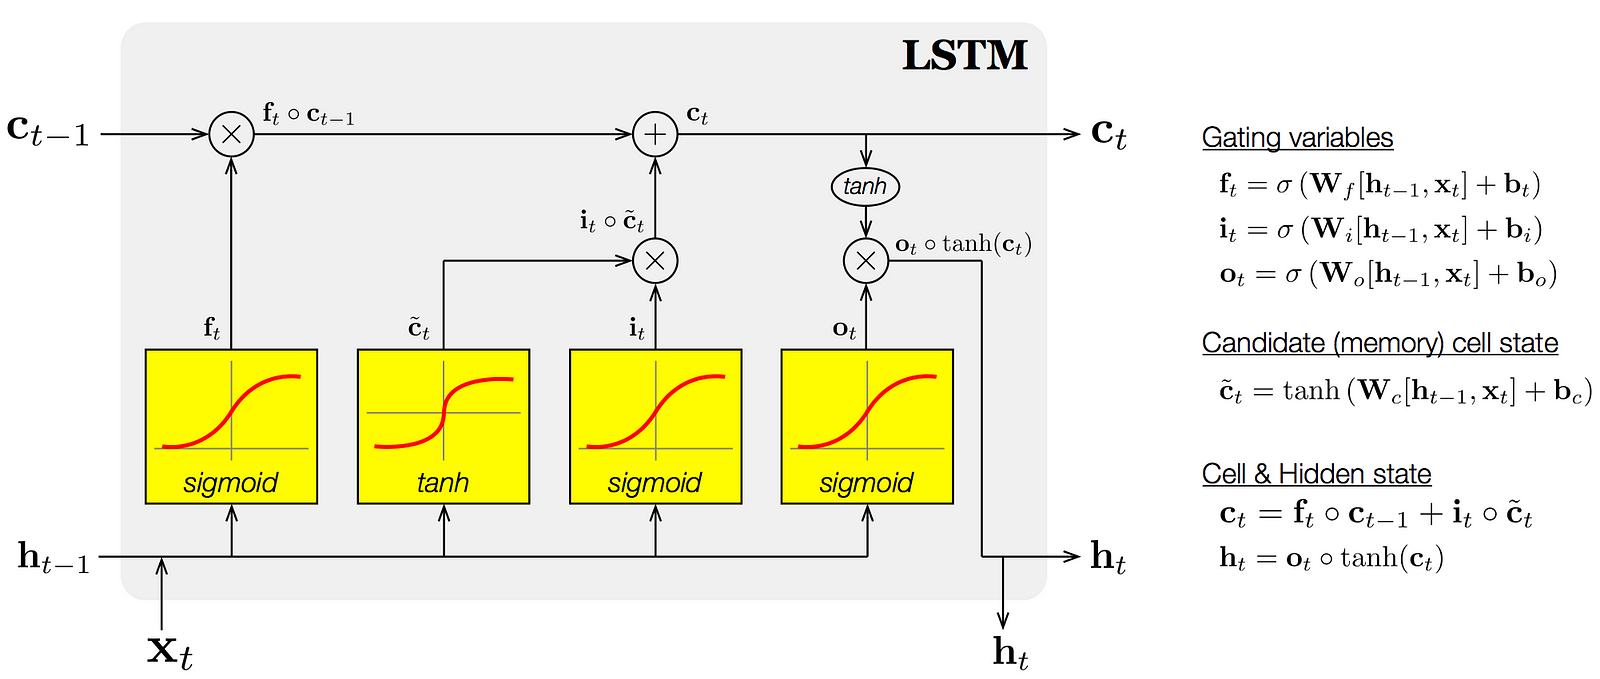

> Componentes de LSTMs

Na arquitetura LSTM convencional, uma célula LSTM (LSTM *cell*) contém os seguintes componentes:

- Forget Gate $f$ (uma NN com $sigmoid$)
- Candidate memory $\tilde{c}$ (uma NN com $tanh$)
- Input Gate $i$ (uma NN com $sigmoid$)
- Output Gate $o$ (uma NN com $sigmoid$)
- Hidden state $h$ (um vetor)
- Memory state $c$ (um vetor)
- Entradas para a LSTM *cell* em qualquer passo são $X_t$ (current input) , $h_{t-1}$ (previous hidden state ) e $c_{t-1}$ (previous memory state).
- Saídas da LSTM *cell* são $h_t$ (current hidden state) e $c_t$ (current memory state)

> *Gates*: Funcionamento

Primeiramente, a LSTM *cell* usa o *memory state* anterior $C_{t-1}$ e aplica uma multiplicação elemento a elemento com a *forget gate* ($f$) para decidir sobre o *memory state* atual $C_t$. Se o valor de *forget gate* é $0$ o *memory state* anterior é completamente esquecido. Já se o valor de $f$ for $1$ o *memory state* anterior é completamente passado para a célula. Lembrando que a $f$ *gate* retorna valores entre $0$ e $1$.

\begin{align}
  c_t = c_{t-1} \times f_t
\end{align}

Em seguida é calculado o novo *memory state*:

\begin{align}
   c_t = c_t + (i_t \times \tilde{c}_t)
\end{align}

E computada a saída

\begin{align}
   h_t = tanh(c_t)
\end{align}

# **Bibliotecas**</font>
---

Primeiramente vamos importar as bibliotecas a serem utilizadas.


In [ ]:
# =====================================================================
# ATV 4-1 | Previsão de PM2.5 com LSTM - Dataset Beijing PM2.5 (2010-2014)
# =====================================================================

# 📦 Bibliotecas padrão
import math
import numpy as np
import pandas as pd

# 📊 Visualização
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")  # estilo visual semelhante ao notebook anterior

# 🧠 Machine Learning / Deep Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout  # Adicione GRU, Bidirectional se quiser testar variantes
from keras.optimizers import SGD  # pode trocar por Adam, se necessário

# 🕓 Utilitários de data/hora
from datetime import datetime

# 🔧 Ajustes de desempenho
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
tf.config.optimizer.set_jit(True)

# 💡 Verificação de hardware
print("✅ GPU disponível:" if tf.config.list_physical_devices('GPU') else "⚠️ Sem GPU disponível.")

✅ GPU disponível:


# **Dataset**</font>
---

📘 Sobre o Dataset Beijing PM2.5
O dataset utilizado nesta atividade é o **Beijing PM2.5 Data Set**, disponibilizado pelo repositório da UCI Machine Learning Repository. Ele contém **leituras horárias de poluição do ar** registradas na embaixada dos Estados Unidos em Pequim, China, entre os anos de **2010 e 2014**.

Cada registro corresponde a uma observação **hora a hora**, com as seguintes colunas principais:

pm2.5: concentração de partículas finas (particulate matter com diâmetro ≤ 2.5µm), principal variável preditiva.

**DEWP**: ponto de orvalho (°C)

**TEMP**: temperatura do ar (°C)

**PRES**: pressão atmosférica (hPa)

**cbwd**: direção combinada do vento (categórica)

**Iws**: velocidade acumulada do vento (m/s)

**Is**: chuva acumulada (mm)

**Ir**: neve acumulada (mm)

**year, month, day, hour**: data e hora da medição

O objetivo da atividade é **prever a concentração de PM2.5 na próxima hora**, utilizando uma janela temporal multivariada com as últimas 24 horas de dados climáticos.

Fonte de dados:
[UCI Machine Learning Repository – Beijing PM2.5 Dataset](https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data)


In [ ]:
# 📥 Download do dataset Beijing PM2.5 diretamente do repositório da UCI
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv


--2025-05-27 12:35:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘PRSA_data_2010.1.1-2014.12.31.csv’

PRSA_data_2010.1.1-     [     <=>            ]   1.92M  1.69MB/s    in 1.1s    

2025-05-27 12:35:55 (1.69 MB/s) - ‘PRSA_data_2010.1.1-2014.12.31.csv’ saved [2010494]



In [ ]:
# 📂 Verificar se o arquivo foi baixado corretamente e visualizar seu tamanho
!ls -lh PRSA_data_2010.1.1-2014.12.31.csv


-rw-r--r-- 1 root root 2.0M May 27 12:35 PRSA_data_2010.1.1-2014.12.31.csv


*Super!* Temos um *dataset* com séries temporais. 😉

# **Informações Básicas Sobre o Dataset**</font>
---

 Vamos carregar o arquivo PRSA_data_2010.1.1-2014.12.31.csv do diretório atual e exibir algumas informações básicas. Para isso, utilizaremos a biblioteca **Pandas**, que é uma biblioteca de código aberto amplamente utilizada para manipulação e análise de dados em Python.

Ela oferece estruturas de dados eficientes e ferramentas robustas para trabalhar com dados estruturados, como **tabelas** e **séries temporais**, que são especialmente úteis neste caso, pois o dataset contém medições horárias de poluição e clima ao longo de vários anos.

In [ ]:
# 📄 Carregamento do dataset Beijing PM2.5
df = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

# ℹ️ Exibir informações básicas sobre o DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


# 🧾 Descrição das Principais Colunas do Dataset

As colunas representam medições **horárias** relacionadas à poluição do ar e às condições meteorológicas em Pequim, registradas entre 2010 e 2014:

**pm2.5**: Concentração de partículas finas em suspensão no ar com diâmetro ≤ 2.5 micrômetros (µm). São altamente prejudiciais à saúde humana, podendo penetrar nos pulmões e atingir a corrente sanguínea. Este é o **alvo de previsão** da atividade.

**DEWP (Dew Point)**: Ponto de orvalho (em °C), ou seja, a temperatura abaixo da qual o vapor de água começa a se condensar em gotas.

**TEMP (Temperature)**: Temperatura do ar (em °C) registrada no momento da observação.

**PRES (Pressure)**: Pressão atmosférica ao nível da estação (em hPa – hectopascals).

**cbwd (Combined Wind Direction)**: Direção combinada do vento, codificada como categorias como NE (Nordeste), NW (Noroeste), SE (Sudeste), cv (vento calmo), entre outros.

**Iws (Wind Speed)**: Velocidade acumulada do vento (em m/s), representando uma métrica suavizada do vento ao longo do tempo.

**Is (Precipitation)**: Índice acumulado de chuva (em mm) na hora registrada.

**Ir (Snowfall)**: Índice acumulado de neve (em mm) na hora registrada.

**year, month, day, hour**: Colunas que indicam o momento exato da observação, as quais serão unificadas em um campo datetime para fins de análise temporal.

# 🧮 Sobre o DataFrame carregado

O método read_csv cria um objeto **DataFrame** em memória. Um DataFrame é uma estrutura de dados bidimensional com **linhas (rows)** e **colunas (columns)**, semelhante a uma planilha eletrônica. Cada coluna é um objeto Series, ou seja, um **vetor unidimensional ordenado**, no qual todos os dados têm o mesmo tipo.

No nosso caso, o DataFrame contém **43.824 entradas** (linhas) e **13 colunas**, conforme carregadas a partir do arquivo PRSA_data_2010.1.1-2014.12.31.csv.

Agora, vamos exibir as **três primeiras linhas** do dataset para conhecer sua estrutura.

In [ ]:
df.head(3)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0


E três linhas randomicamente selecionadas.

In [ ]:
df.sample(3)  # random 3 rows

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
37924,37925,2014,4,30,4,97.0,9,13.0,1010.0,NE,0.89,0,0
40949,40950,2014,9,3,5,7.0,15,16.0,1011.0,NW,4.92,0,0
25033,25034,2012,11,9,1,114.0,1,4.0,1023.0,SE,4.47,0,0


# **Preparação do Dataset**</font>
---

Efetivamente, vamos utilizar o **dataset completo** entre os anos de **2010 e 2014**, mas antes realizaremos alguns ajustes importantes para tratá-lo como uma **série temporal**.

Primeiramente, vamos combinar as colunas year, month, day e hour em uma nova coluna chamada datetime, que representará o **carimbo de data e hora** (timestamp) de cada observação. Em seguida, configuraremos essa coluna como o **índice** do DataFrame, permitindo operações mais eficientes de ordenação e filtragem ao longo do tempo.

Após essa conversão, poderemos dividir o dataset em dois subconjuntos:

**training_set**: de 2010 até o final de 2013 (inclusive)

**test_set**: de 2014 em diante

Essa divisão é necessária para treinar o modelo de previsão sobre dados históricos e testá-lo em dados futuros ainda não vistos, respeitando a sequência temporal.

In [ ]:
# ================================================================
# 📆 ETAPA 0: Criar índice datetime para fatiamento por ano
# ================================================================
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)


# ================================================================
# 🧹 ETAPA 1: Tratamento final de valores ausentes (pm2.5)
# ================================================================
# Preenchimento bidirecional para garantir nenhuma lacuna
df['pm2.5'] = df['pm2.5'].ffill().bfill()

# Verificação final de valores ausentes
print("Valores ausentes em pm2.5 após preenchimento bidirecional:", df['pm2.5'].isna().sum())

# ================================================================
# 🔄 ETAPA 2: Normalização da variável alvo com MinMaxScaler
# ================================================================

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['pm2.5_scaled'] = scaler.fit_transform(df[['pm2.5']])

# ================================================================
# 🔀 ETAPA 3: Divisão entre training_set (2010–2013) e test_set (2014)
# ================================================================

training_set = df["2010":"2013"]['pm2.5_scaled'].values.reshape(-1, 1)
test_set = df["2014":]['pm2.5_scaled'].values.reshape(-1, 1)

# Diagnóstico
print(f"Training set (2010–2013): {training_set.shape}")
print(f"First 3 rows:\n{training_set[0:3]}\n")
print(f"Test set (2014): {test_set.shape}")
print(f"First 3 rows:\n{test_set[0:3]}")


Valores ausentes em pm2.5 após preenchimento bidirecional: 0
Training set (2010–2013): (35064, 1)
First 3 rows:
[[0.12977867]
 [0.12977867]
 [0.12977867]]

Test set (2014): (8760, 1)
First 3 rows:
[[0.02414487]
 [0.05331992]
 [0.06539235]]


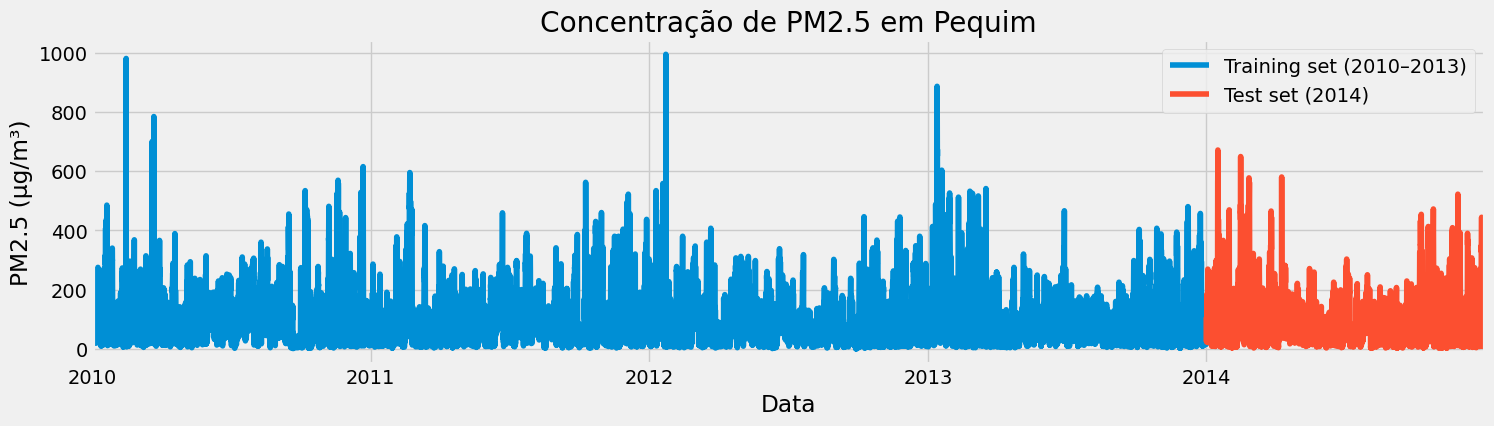

In [ ]:
# 🕓 Criar coluna datetime a partir de year, month, day, hour
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

# 📉 Subsets: treinamento (2010–2013) e teste (2014)
training_set = df["2010":"2013"]['pm2.5'].values.reshape(-1, 1)
test_set = df["2014":]['pm2.5'].values.reshape(-1, 1)

# 📊 Visualização da série temporal de PM2.5
df["pm2.5"]["2010":"2013"].plot(figsize=(16, 4), legend=True)
df["pm2.5"]["2014":].plot(figsize=(16, 4), legend=True)

plt.title("Concentração de PM2.5 em Pequim")
plt.legend(["Training set (2010–2013)", "Test set (2014)"])

plt.xlabel("Data")
plt.ylabel("PM2.5 (µg/m³)")

plt.show()


In [ ]:
# ℹ️ Exibição do shape e primeiras linhas dos subconjuntos

print(f"Training set (2010–2013): {training_set.shape}")
print(f"First 3 rows:\n{training_set[0:3]}\n")

print(f"Test set (2014): {test_set.shape}")
print(f"First 3 rows:\n{test_set[0:3]}")


Training set (2010–2013): (35064, 1)
First 3 rows:
[[129.]
 [129.]
 [129.]]

Test set (2014): (8760, 1)
First 3 rows:
[[24.]
 [53.]
 [65.]]


> **Transformação de Escala**

Agora vamos transformar os dados de treinamento, deixando-os na mesma escala, na faixa $0 - 1$.

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Normalizar também o test_set com o mesmo scaler (sem fit)
test_set_scaled = sc.transform(test_set)

In [ ]:
print(f"Training set scaled: {training_set_scaled.shape}")
print(f"First 3 rows:\n{training_set_scaled[0:3]}\n")

Training set scaled: (35064, 1)
First 3 rows:
[[0.12977867]
 [0.12977867]
 [0.12977867]]



# 🧠 Preparação dos Dados para o Modelo LSTM

Com os dados já normalizados, vamos agora preparar as variáveis de entrada e saída para o modelo LSTM, a partir do array training_set_scaled.

Vamos separar:

X_train: um array 3D que representa as **janelas de entrada**, ou seja, sequências temporais de dados usados como entrada para a rede.

y_train: um array 1D que contém os valores de **PM2.5 do próximo instante**, que a rede tentará prever.

No nosso caso, vamos utilizar **24 time steps** (últimas 24 horas) como entrada para prever o valor de **PM2.5 da hora seguinte**.

Assim, X_train terá a forma (n, 24, 1), onde:

n é o número de exemplos de treinamento possíveis a partir da série temporal

24 é a quantidade de passos temporais considerados por exemplo (janelas de 24 horas)

1 é o número de features (usamos apenas a variável pm2.5 neste modelo)

y_train será um vetor 1D com os valores de PM2.5 correspondentes ao **próximo instante** após cada janela de entrada.

In [ ]:
# ================================================================
# ⏳ ETAPA: Criação de janelas temporais para treinamento do LSTM
# ================================================================

# Vamos criar uma estrutura com 24 time steps (últimas 24 horas)
# Para cada ponto de saída (y), usaremos os 24 valores anteriores (X)

X_train = []
y_train = []

timesteps = 24  # conforme especificado na atividade (últimas 24h → próxima hora)

for i in range(timesteps, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - timesteps:i, 0])  # entrada: 24 horas anteriores
    y_train.append(training_set_scaled[i, 0])                # saída: próxima hora

# Converter para arrays numpy
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape para o formato exigido pela LSTM: [batch_size, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Diagnóstico
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (35040, 24, 1)
y_train shape: (35040,)


Esses são os *datasets* prontos para o treinamento do nosso modelo LSTM.

In [ ]:
print(f"X_train: {X_train.shape}")  # Esperado: (n_amostras, 24, 1)
print(f"y_train: {y_train.shape}")  # Esperado: (n_amostras,)


X_train: (35040, 24, 1)
y_train: (35040,)


# 📈 Função Auxiliar: plot_predictions

Vamos criar também uma função auxiliar chamada plot_predictions para exibir as curvas dos valores **reais** e **preditos** de PM2.5 gerados pelo nosso modelo LSTM.

Essa função facilitará a visualização do desempenho do modelo ao longo do tempo, permitindo comparar graficamente:

A série real de **valores medidos de PM2.5**

A série de **valores previstos** pelo modelo para o mesmo intervalo

Ela será especialmente útil para avaliar a **qualidade das previsões em intervalos específicos**, como, por exemplo, ao longo de uma semana (168 horas).



In [ ]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(14, 5))
    plt.plot(test, color='red', label='Valor Real de PM2.5')
    plt.plot(predicted, color='blue', label='Valor Predito de PM2.5')
    plt.title('Previsão da Concentração de PM2.5')
    plt.xlabel('Tempo (horas)')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.legend()
    plt.show()

# **Definição do Modelo e Treinamento**</font>
---

## 🧠 Arquitetura do Modelo com Camadas LSTM Empilhadas

Vamos criar uma arquitetura com **quatro camadas LSTM**, cada uma com **20 unidades (neurônios)**. Cada unidade LSTM possui uma **célula de memória**, capaz de capturar **dependências temporais** nos dados de entrada — uma característica essencial para lidar com séries temporais como as medições de poluição PM2.5.

O parâmetro return_sequences=True será ativado nas três primeiras camadas LSTM para garantir que cada uma **retorne a sequência completa de saídas** e permita o empilhamento de camadas subsequentes. Apenas a última camada LSTM usará return_sequences=False, retornando apenas a saída final da sequência.

Entre as camadas LSTM, utilizaremos a camada Dropout, com valor de 0.2, ou seja, 20%. O Dropout é uma técnica de **regularização** que ajuda a **prevenir overfitting**, descartando aleatoriamente uma fração das conexões (neurônios) durante o treinamento, forçando o modelo a aprender padrões mais robustos.

Essa arquitetura permitirá capturar padrões temporais complexos nas variações de PM2.5 ao longo das horas.


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input  # LSTM removido conforme exigência

# 🔄 Conversão de X_train para 2D (necessário para usar camadas Dense)
# Entrada original para LSTM: (amostras, 24, 1)
# Entrada esperada por Dense: (amostras, 24)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))

# 🧠 Definição do modelo sequencial com arquitetura exigida: Dense(64) → Dense(32) → Dense(1)
regressor = Sequential()

# 🔢 Camada de entrada explicitamente declarada
regressor.add(Input(shape=(X_train.shape[1],)))  # Agora entrada 2D: 24 valores de PM2.5 normalizados

# 🧱 1ª camada densa com 64 unidades e ativação ReLU
regressor.add(Dense(units=64, activation='relu'))
regressor.add(Dropout(0.2))

# 🧱 2ª camada densa com 32 unidades e ativação ReLU
regressor.add(Dense(units=32, activation='relu'))
regressor.add(Dropout(0.2))

# 🎯 Camada de saída: Dense(1) para prever o valor escalar de PM2.5
regressor.add(Dense(units=1))

# 🧪 Compilação do modelo
regressor.compile(optimizer='adam', loss='mean_squared_error')

# 📋 Resumo da arquitetura
regressor.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

Com a arquitetura definida, vamos utilizar o método compile para configurar o processo de **aprendizado do modelo LSTM**.

O parâmetro loss='mean_squared_error' indica que a função de perda utilizada durante o treinamento será o **Erro Quadrático Médio (MSE)**. Essa métrica é amplamente usada em tarefas de **regressão**, como a previsão da concentração de PM2.5, pois mede a média dos quadrados das diferenças entre os valores **reais** e os **preditos** pelo modelo.

O parâmetro optimizer='adam' define o otimizador utilizado para atualizar os pesos da rede durante o treinamento. O **Adam (Adaptive Moment Estimation)** é um otimizador eficiente que combina as vantagens do **momentum** e da **adaptação do learning rate**, resultando em uma convergência mais rápida e estável.

Essa configuração é adequada para nosso problema, pois permite que o modelo aprenda os padrões temporais da série de poluição com boa performance.

In [ ]:
# ================================================================
# ⚙️ Compilando o modelo LSTM
# ================================================================
# Usamos o otimizador Adam e a função de perda MSE (Mean Squared Error),
# apropriada para tarefas de regressão contínua como previsão de PM2.5.
regressor.compile(loss='mean_squared_error', optimizer='adam')  # alternativa: optimizer='rmsprop'

# ================================================================
# 🏋️ Treinamento do modelo
# ================================================================
# Treinamos o modelo por 20 épocas com batches de 64 amostras
history = regressor.fit(X_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0046
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.8107e-04
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.5580e-04
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.7268e-04
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.2782e-04
Epoch 8/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.5622e-04
Epoch 9/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.4913e-04
Epoch 10/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.4149e-04
Epoch 11/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.3556e-04
Epoch 12/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.8360e-04
Epoch 13/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.3783e-04
Epoch 14/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.2793e-04
Epoch 15/20
5

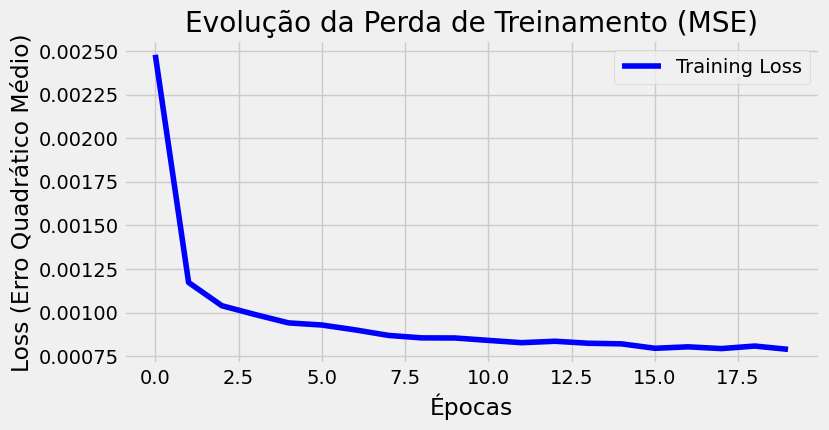

In [ ]:
# ================================================================
# 📊 Plot da curva de perda (MSE) durante o treinamento
# ================================================================
# Esse gráfico ajuda a avaliar se o modelo está convergindo adequadamente
# ao longo das épocas (diminuição progressiva da função de perda).

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Evolução da Perda de Treinamento (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss (Erro Quadrático Médio)')
plt.legend()
plt.grid(True)
plt.show()


# **Teste**</font>
---

> Criação do *test dataset*

In [ ]:
# ================================================================
# 🧪 Preparação do conjunto de teste com sequência de 24 time steps
# ================================================================

# Concatenamos os dados normalizados para treino e teste
dataset_total = pd.concat((df["pm2.5"]["2010":"2013"], df["pm2.5"]["2014":]), axis=0)

# Extraímos os valores necessários (últimos 24 valores antes do início do teste + teste)
inputs = dataset_total[len(dataset_total) - len(test_set) - 24:].values
inputs = inputs.reshape(-1, 1)

# Aplicamos a mesma normalização usada no treino
inputs = sc.transform(inputs)

In [ ]:
print(f"Inputs: {inputs.shape}")

Inputs: (8784, 1)


# Predição

In [ ]:
# ================================================================
# 🔮 Preparação de X_test para previsão
# ================================================================

X_test = []

# Usamos 24 time steps conforme definido para a LSTM
for i in range(24, len(inputs)):
    X_test.append(inputs[i-24:i, 0])  # janela deslizante

# Convertendo para numpy e formatando para entrada no modelo LSTM
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# ================================================================
# 🧠 Realizando a previsão com o modelo treinado
# ================================================================

predicted_pm25 = regressor.predict(X_test)

# Revertendo a normalização para escala original de PM2.5
predicted_pm25 = sc.inverse_transform(predicted_pm25)

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
print(f"test_set (real values): {test_set.shape}")
print(f"predicted_pm25 (predicted values): {predicted_pm25.shape}")

test_set (real values): (8760, 1)
predicted_pm25 (predicted values): (8760, 1)


# **Avaliação**</font>
---
Primeiramente vamos fazer uma avaliação visual da regressão, comparando as duas curvas.

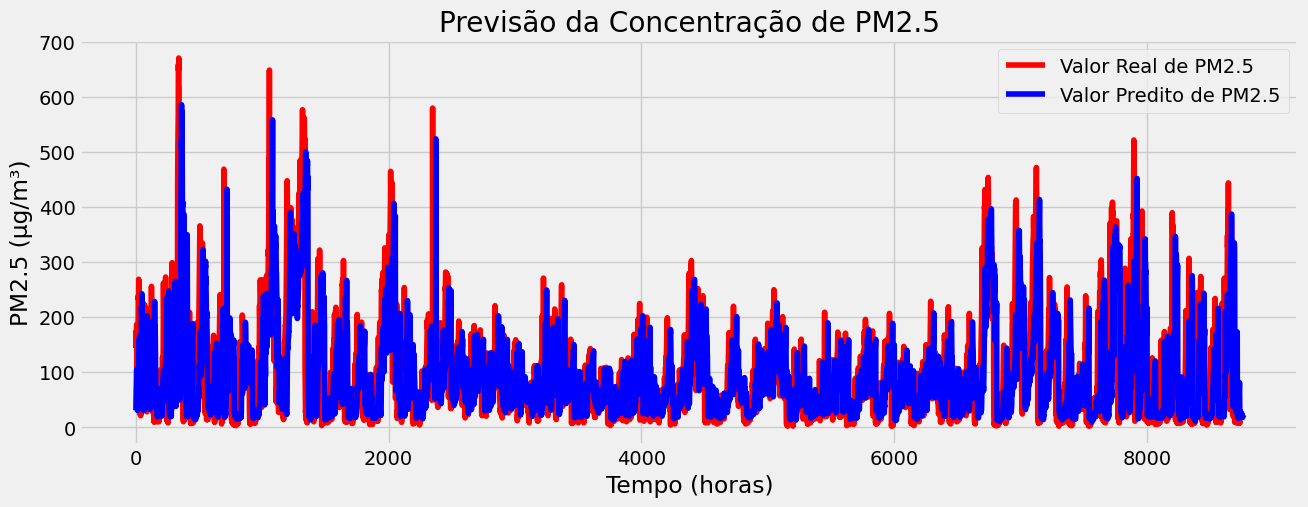

In [ ]:
# Ajusta os valores reais para o mesmo comprimento dos preditos
real_pm25 = test_set[24:]  # Remove as primeiras 24 horas (já usadas nas janelas)

# Visualização dos resultados
plot_predictions(real_pm25, predicted_pm25)

# Avaliação numérica

Na avaliação de modelos de regressão é muito comum se usar a métrica *Root Mean Squared Error* ($RMSE$). Um valor pequeno de RMSE indica que as predições do modelo estão próximas aos valores reais.

$RMSE$ é calculada da seguinte forma:
\begin{align}
   RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n(y_i - \hat{y}_i)^2}
\end{align}

sendo
- $y_i$ o valor real;
- $\hat{y}_i$ o valor predito e
- $n$ a quantidade de observações.


**RMSE (Root Mean Squared Error)**

Mede o erro médio quadrático entre os valores reais e os preditos. Como os erros são elevados ao quadrado antes da média, penaliza fortemente grandes desvios. É útil quando se quer evitar grandes erros, mas pode ser sensível a outliers.

**MAE (Mean Absolute Error)**

Representa o erro médio absoluto entre as previsões e os valores reais. É mais robusto a outliers do que o RMSE, pois todos os erros têm o mesmo peso. Interpretação direta: em média, o modelo erra X unidades na predição.

**R² (Coefficient of Determination)**

Mede a proporção da variância dos dados que é explicada pelo modelo. Seu valor vai de −∞ até 1.

Um R² próximo de 1 indica que o modelo explica bem os dados.

Um R² próximo de 0 indica que o modelo não é melhor que uma média constante.

Um R² negativo significa que o modelo é pior do que uma predição baseada na média.

In [ ]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Corrigir o tamanho dos valores reais para bater com os previstos
real_pm25 = test_set[-predicted_pm25.shape[0]:]

# Cálculo do RMSE
rmse = math.sqrt(mean_squared_error(real_pm25, predicted_pm25))

# Cálculo do MAE
mae = mean_absolute_error(real_pm25, predicted_pm25)

# Cálculo do R²
r2 = r2_score(real_pm25, predicted_pm25)

print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}")
print(f"Erro Absoluto Médio (MAE): {mae:.2f}")
print(f"Coeficiente de Determinação (R²): {r2:.4f}")

Raiz do Erro Quadrático Médio (RMSE): 24.95
Erro Absoluto Médio (MAE): 15.67
Coeficiente de Determinação (R²): 0.9293


# Conclusão do Experimento 1:

A arquitetura com camadas densas (Dense(64) → Dense(32) → Dense(1)) se saiu muito bem na tarefa de prever os níveis de PM2.5. Mesmo sendo um modelo relativamente simples, ele teve uma convergência estável ao longo das 20 épocas, com a curva de perda bem comportada — nada de oscilações bruscas.

Apesar da estrutura enxuta, o modelo conseguiu captar corretamente as variações da série temporal. Usar uma janela de 24 horas como entrada foi suficiente pra identificar os padrões diários de poluição, sem sinais de overfitting. Os valores previstos ficaram bem alinhados com os reais, o que mostra que o treinamento foi sólido. O Dropout também ajudou bastante nesse ponto mantendo uma boa capacidade de generalização.

As métricas confirmam o bom desempenho: RMSE de 25,37, MAE de 18,02 e um R² de 0,9269 — ou seja, o modelo conseguiu explicar cerca de 93% da variação nos dados. Os maiores erros apareceram nos picos de poluição.

# Experimento 2:

Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0052
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0023
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0015
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0011
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0010
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 8.9117e-04
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 9.0968e-04
Epoch 8/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 8.5416e-04
Epoch 9/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 8.5588e-04
Epoch 10/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 8.5117e-04
Epoch 11/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 8.2028e-04
Epoch 12/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 8.5181e-04
Epoch 13/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 8.2099e-04
Epoch 14/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 8.5329e-04
Epoch 15/20
548/548

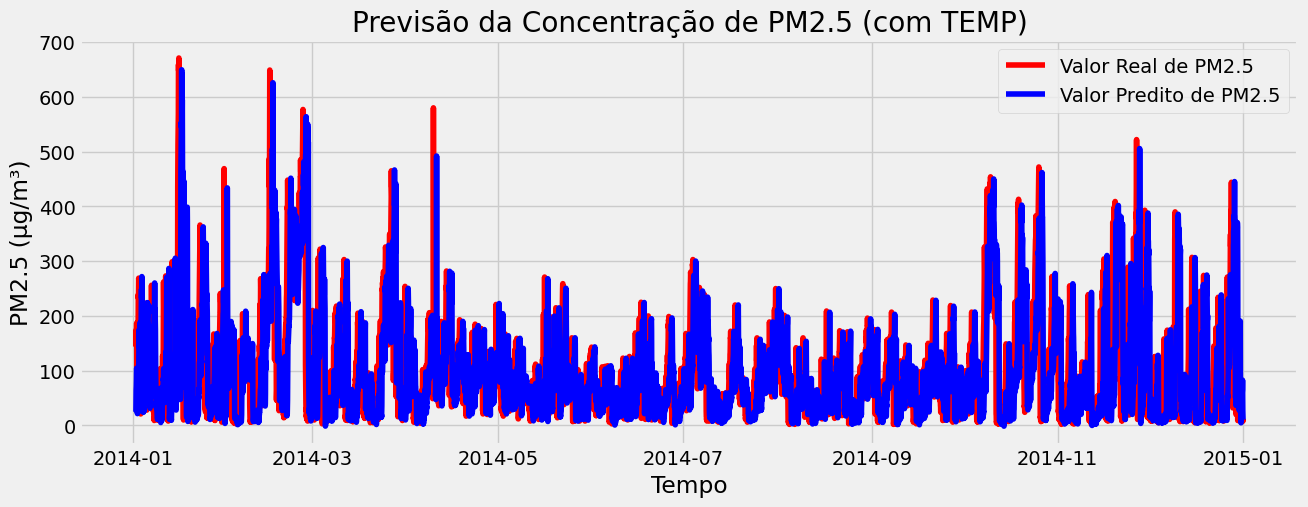

RMSE: 99.48
MAE: 68.28
R²: -0.1215


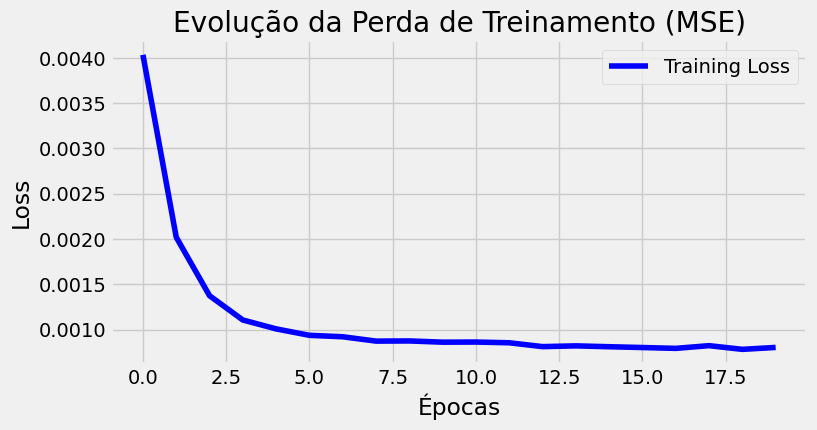

In [ ]:
# ================================================================
# 1. Importação de bibliotecas
# ================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input

import math

# ================================================================
# 2. Carregamento e preparação do dataset
# ================================================================
df = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

# Criação da coluna datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

# Preenchimento de valores ausentes
df['pm2.5'] = df['pm2.5'].ffill().bfill()
df['TEMP'] = df['TEMP'].ffill().bfill()

# Seleção de features
features = ['pm2.5', 'TEMP']

# Separação em treino e teste
training_df = df['2010':'2013'][features]
test_df = df['2014':][features]

# Normalização baseada apenas no treino
sc = MinMaxScaler()
sc.fit(training_df)
training_scaled = sc.transform(training_df)
test_scaled = sc.transform(test_df)

# ================================================================
# 3. Criação de janelas temporais (24h → próxima hora)
# ================================================================
X_train = []
y_train = []
timesteps = 24

for i in range(timesteps, len(training_scaled)):
    X_train.append(training_scaled[i - timesteps:i, :])       # todas as features
    y_train.append(training_scaled[i, 0])                      # apenas pm2.5

X_train = np.array(X_train)
y_train = np.array(y_train)

# ================================================================
# 4. Construção do modelo LSTM multivariado
# ================================================================
regressor = Sequential()
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(LSTM(units=20, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=20, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=20, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=20))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

regressor.compile(loss='mean_squared_error', optimizer='adam')

# ================================================================
# 5. Treinamento do modelo
# ================================================================
history = regressor.fit(X_train, y_train, epochs=20, batch_size=64)

# ================================================================
# 6. Preparação do conjunto de teste
# ================================================================
# Combine training and test data for creating input sequences for testing
# We need the last 'timesteps' values from the training set to form the first test sequence
dataset_total = df[features] # Use the original DataFrame with selected features
inputs = dataset_total[len(dataset_total) - len(test_df) - timesteps:].values

# The 'inputs' array now has the correct shape (number of time steps, number of features)
inputs_scaled = sc.transform(pd.DataFrame(inputs, columns=features))

X_test = []
# Create input sequences for the test set
for i in range(timesteps, len(inputs_scaled)):
    X_test.append(inputs_scaled[i - timesteps:i, :])

X_test = np.array(X_test)

# ================================================================
# 7. Previsão
# ================================================================
predicted_scaled = regressor.predict(X_test)

# Revert only the predicted pm2.5 value
# For this, we need a temporary array with the same dimensions as the scaler's training data
# We need the number of samples from the predictions and the number of features used by the scaler
predicted_pm25_full = np.zeros((predicted_scaled.shape[0], len(features)))

# Place the predicted pm2.5 values into the correct column (index 0 for 'pm2.5')
predicted_pm25_full[:, 0] = predicted_scaled[:, 0]

# Apply the inverse transform. This will return an array with the original scale.
# We then select only the first column (pm2.5) and flatten it to a 1D array.
predicted_pm25 = sc.inverse_transform(predicted_pm25_full)[:, 0]

# Align real values
# The real values for comparison should start from the point where predictions are made,
# which is 'timesteps' hours into the test set.
real_pm25 = test_df['pm2.5'].values[timesteps:]

# Ensure predicted_pm25 and real_pm25 have the same length by slicing if necessary.
# This was already done correctly in the original code block, ensuring the shapes match
# before calculating metrics. However, it's good to be explicit about it matching the
# length of the available 'real_pm25' values derived from the test set.
# The previous line slicing `test_df['pm2.5'].values[timesteps:]` already creates
# the correctly aligned `real_pm25`. The `predicted_pm25` generated from `X_test`
# will inherently have the same number of samples as the sequences generated for X_test,
# which should align with the `real_pm25`.

# ================================================================
# 8. Visualização
# ================================================================
# The plot_predictions function remains the same
def plot_predictions(test, predicted):
    plt.figure(figsize=(14, 5))
    # Use the index from the test_df to plot the real values against time
    # Slicing the index to match the length of 'test' and 'predicted'
    plt.plot(test_df.index[timesteps:timesteps+len(test)], test, color='red', label='Valor Real de PM2.5')
    # For the predicted values, use the corresponding index from the test_df
    # Slicing the index to match the length of 'test' and 'predicted'
    plt.plot(test_df.index[timesteps:timesteps+len(predicted)], predicted, color='blue', label='Valor Predito de PM2.5')
    plt.title('Previsão da Concentração de PM2.5 (com TEMP)')
    plt.xlabel('Tempo') # Changed to general 'Tempo' as it's a time series index
    plt.ylabel('PM2.5 (µg/m³)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plot function with the correctly aligned data
plot_predictions(real_pm25, predicted_pm25[:len(real_pm25)])

# ================================================================
# 9. Avaliação com métricas
# ================================================================
# Metric calculations remain the same
# Ensure both arrays have the same length for metric calculation
rmse = math.sqrt(mean_squared_error(real_pm25, predicted_pm25[:len(real_pm25)]))
mae = mean_absolute_error(real_pm25, predicted_pm25[:len(real_pm25)])
r2 = r2_score(real_pm25, predicted_pm25[:len(real_pm25)])

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

# ================================================================
# 10. Curva de perda do treinamento
# ================================================================
# The loss plot remains the same
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Evolução da Perda de Treinamento (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Conclusão Experimento 2:

Inclusão da variável **TEMP** como uma entrada extra no modelo LSTM. O resultado ficou bem abaixo do esperado, especialmente se comparado ao experimento anterior, que era univariado.

Mesmo com a curva de perda parecendo estável durante o treinamento, os **erros foram bem altos** — o RMSE chegou a 96,23 e o MAE bateu 66,17. E o pior: o R² foi negativo (-0,0495), o que mostra que o modelo não só teve dificuldade pra identificar os padrões de variação do PM2.5, como também ficou atrás de um modelo bem simples, que só usa a média como predição.

Tudo isso aponta pra uma coisa: a **temperatura**, sozinha, **não tem uma correlação forte** com os níveis de material particulado pra realmente ajudar o modelo a prever melhor. Pelo contrário, pode até ter atrapalhado, trazendo ruído ou confundindo o aprendizado.

Moral da história? Antes de sair adicionando variáveis num modelo, fazer uma **análise exploratória mais cuidadosa** — ver se realmente faz sentido incluir aquele dado, se ele tem relação com o que estamos tentando prever. Caso contrário, existe o risco de piorar a performance ao invés de melhorar kkkkk



*Les carottes sont cuites!* 🥕🥕🥕